In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-wordcloud-mask/twitter-mask.png
/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [7]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import warnings 

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from PIL import Image

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# plotting
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import requests

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)

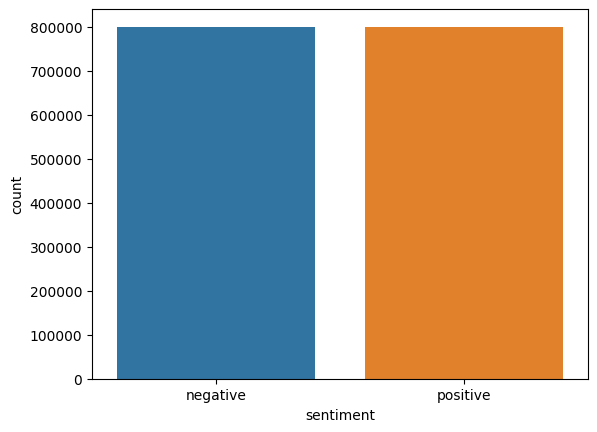

In [8]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
df = df[['sentiment','text']]
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
sns.countplot(x='sentiment', data=df)

# Set the x-axis tick labels to "negative" and "positive"
plt.xticks(ticks=[0,1], labels=['negative', 'positive'])

# Show the plot
plt.show()

In [9]:
df.head(5)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


**Step - 2 : Data Pre-processing**

In [11]:
# Confirming presence of missing values in each variable
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [12]:
# Including Stopwords and exclusing 'not' adding 'quot'

stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'quot', 'amp'}
stop_words = stop_words.union(more_stopwords)
                 
stemmer = SnowballStemmer("english")

In [13]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMOPOS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMOPOS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMOPOS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMONEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMONEG ', tweet)
    return tweet

def preprocess(text):
    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    nonalpharithmeticPattern = "[^a-zA-Z]"
    
    # Replaces URLs with the word URL
    text = re.sub(urlPattern,' ',text)
    # Replaces @ MENTIONS 
    text = re.sub(userPattern,' ', text)  
    # Replace emojis with either EMO_POS or EMO_NEG
    #text = handle_emojis(text)
    # Replace all non alpharithmetic.
    text = re.sub(nonalpharithmeticPattern, ' ', text)
    # Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(r"(.)\1\1+", r"\1\1", text)
    # Replaces #hashtag with hashtag
    text = re.sub(r'#(\S+)', r' \1 ', text)
    # Remove words with length <= 2
    text = ' '.join([w for w in text.split() if len(w) > 2])
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text
        
df['mod_text'] = df['text'].apply(lambda x: preprocess(x))
df.head()

,sentiment,text,mod_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aww that bummer You shoulda got David Carr Thi...
1,0,is upset that he can't update his Facebook by ...,upset that can update his Facebook texting and...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball Managed save The...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy and like its fire
4,0,"@nationwideclass no, it's not behaving at all....",not behaving all mad why here because can see ...


In [14]:
# Tokenizing the tweet base texts.

df['tokenized'] = df['mod_text'].apply(word_tokenize)

df.head()

,sentiment,text,mod_text,tokenized
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aww that bummer You shoulda got David Carr Thi...,"[Aww, that, bummer, You, shoulda, got, David, ..."
1,0,is upset that he can't update his Facebook by ...,upset that can update his Facebook texting and...,"[upset, that, can, update, his, Facebook, text..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball Managed save The...,"[dived, many, times, for, the, ball, Managed, ..."
3,0,my whole body feels itchy and like its on fire,whole body feels itchy and like its fire,"[whole, body, feels, itchy, and, like, its, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",not behaving all mad why here because can see ...,"[not, behaving, all, mad, why, here, because, ..."


In [15]:
# Lower casing clean text.

df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

df.head()

,sentiment,text,mod_text,tokenized,lower
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aww that bummer You shoulda got David Carr Thi...,"[Aww, that, bummer, You, shoulda, got, David, ...","[aww, that, bummer, you, shoulda, got, david, ..."
1,0,is upset that he can't update his Facebook by ...,upset that can update his Facebook texting and...,"[upset, that, can, update, his, Facebook, text...","[upset, that, can, update, his, facebook, text..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball Managed save The...,"[dived, many, times, for, the, ball, Managed, ...","[dived, many, times, for, the, ball, managed, ..."
3,0,my whole body feels itchy and like its on fire,whole body feels itchy and like its fire,"[whole, body, feels, itchy, and, like, its, fire]","[whole, body, feels, itchy, and, like, its, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",not behaving all mad why here because can see ...,"[not, behaving, all, mad, why, here, because, ...","[not, behaving, all, mad, why, here, because, ..."


In [16]:
# Removing stopwords.

df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

df.head()

,sentiment,text,mod_text,tokenized,lower,stopwords_removed
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aww that bummer You shoulda got David Carr Thi...,"[Aww, that, bummer, You, shoulda, got, David, ...","[aww, that, bummer, you, shoulda, got, david, ...","[aww, bummer, shoulda, got, david, carr, third..."
1,0,is upset that he can't update his Facebook by ...,upset that can update his Facebook texting and...,"[upset, that, can, update, his, Facebook, text...","[upset, that, can, update, his, facebook, text...","[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball Managed save The...,"[dived, many, times, for, the, ball, Managed, ...","[dived, many, times, for, the, ball, managed, ...","[dived, many, times, ball, managed, save, rest..."
3,0,my whole body feels itchy and like its on fire,whole body feels itchy and like its fire,"[whole, body, feels, itchy, and, like, its, fire]","[whole, body, feels, itchy, and, like, its, fire]","[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",not behaving all mad why here because can see ...,"[not, behaving, all, mad, why, here, because, ...","[not, behaving, all, mad, why, here, because, ...","[not, behaving, mad, see]"


In [17]:
def stem_or_not(word):
    if word in ['emopos', 'emoneg']:
        return word
    else:
        return stemmer.stem(word)
    
df['stemmed'] = df['stopwords_removed'].apply(
lambda x: [stem_or_not(word) for word in x])

df['stemmed'] = df['stemmed'].apply(
    lambda x: [word for word in x if word not in stop_words])

df['stemmed_str'] = [' '.join(map(str, l)) for l in df['stemmed']]

df.head()

,sentiment,text,mod_text,tokenized,lower,stopwords_removed,stemmed,stemmed_str
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aww that bummer You shoulda got David Carr Thi...,"[Aww, that, bummer, You, shoulda, got, David, ...","[aww, that, bummer, you, shoulda, got, david, ...","[aww, bummer, shoulda, got, david, carr, third...","[aww, bummer, shoulda, got, david, carr, third...",aww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset that can update his Facebook texting and...,"[upset, that, can, update, his, Facebook, text...","[upset, that, can, update, his, facebook, text...","[upset, update, facebook, texting, might, cry,...","[upset, updat, facebook, text, might, cri, res...",upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball Managed save The...,"[dived, many, times, for, the, ball, Managed, ...","[dived, many, times, for, the, ball, managed, ...","[dived, many, times, ball, managed, save, rest...","[dive, mani, time, ball, manag, save, rest, bo...",dive mani time ball manag save rest bound
3,0,my whole body feels itchy and like its on fire,whole body feels itchy and like its fire,"[whole, body, feels, itchy, and, like, its, fire]","[whole, body, feels, itchy, and, like, its, fire]","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",not behaving all mad why here because can see ...,"[not, behaving, all, mad, why, here, because, ...","[not, behaving, all, mad, why, here, because, ...","[not, behaving, mad, see]","[not, behav, mad, see]",not behav mad see


In [18]:
df_mod = df[["stemmed_str", "sentiment"]]
df_mod.head()

,stemmed_str,sentiment
0,aww bummer shoulda got david carr third day,0
1,upset updat facebook text might cri result sch...,0
2,dive mani time ball manag save rest bound,0
3,whole bodi feel itchi like fire,0
4,not behav mad see,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_mod['stemmed_str'], df_mod['sentiment'], test_size=0.01, random_state=1)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1584000
TEST size: 16000


**WordCloud analysis**

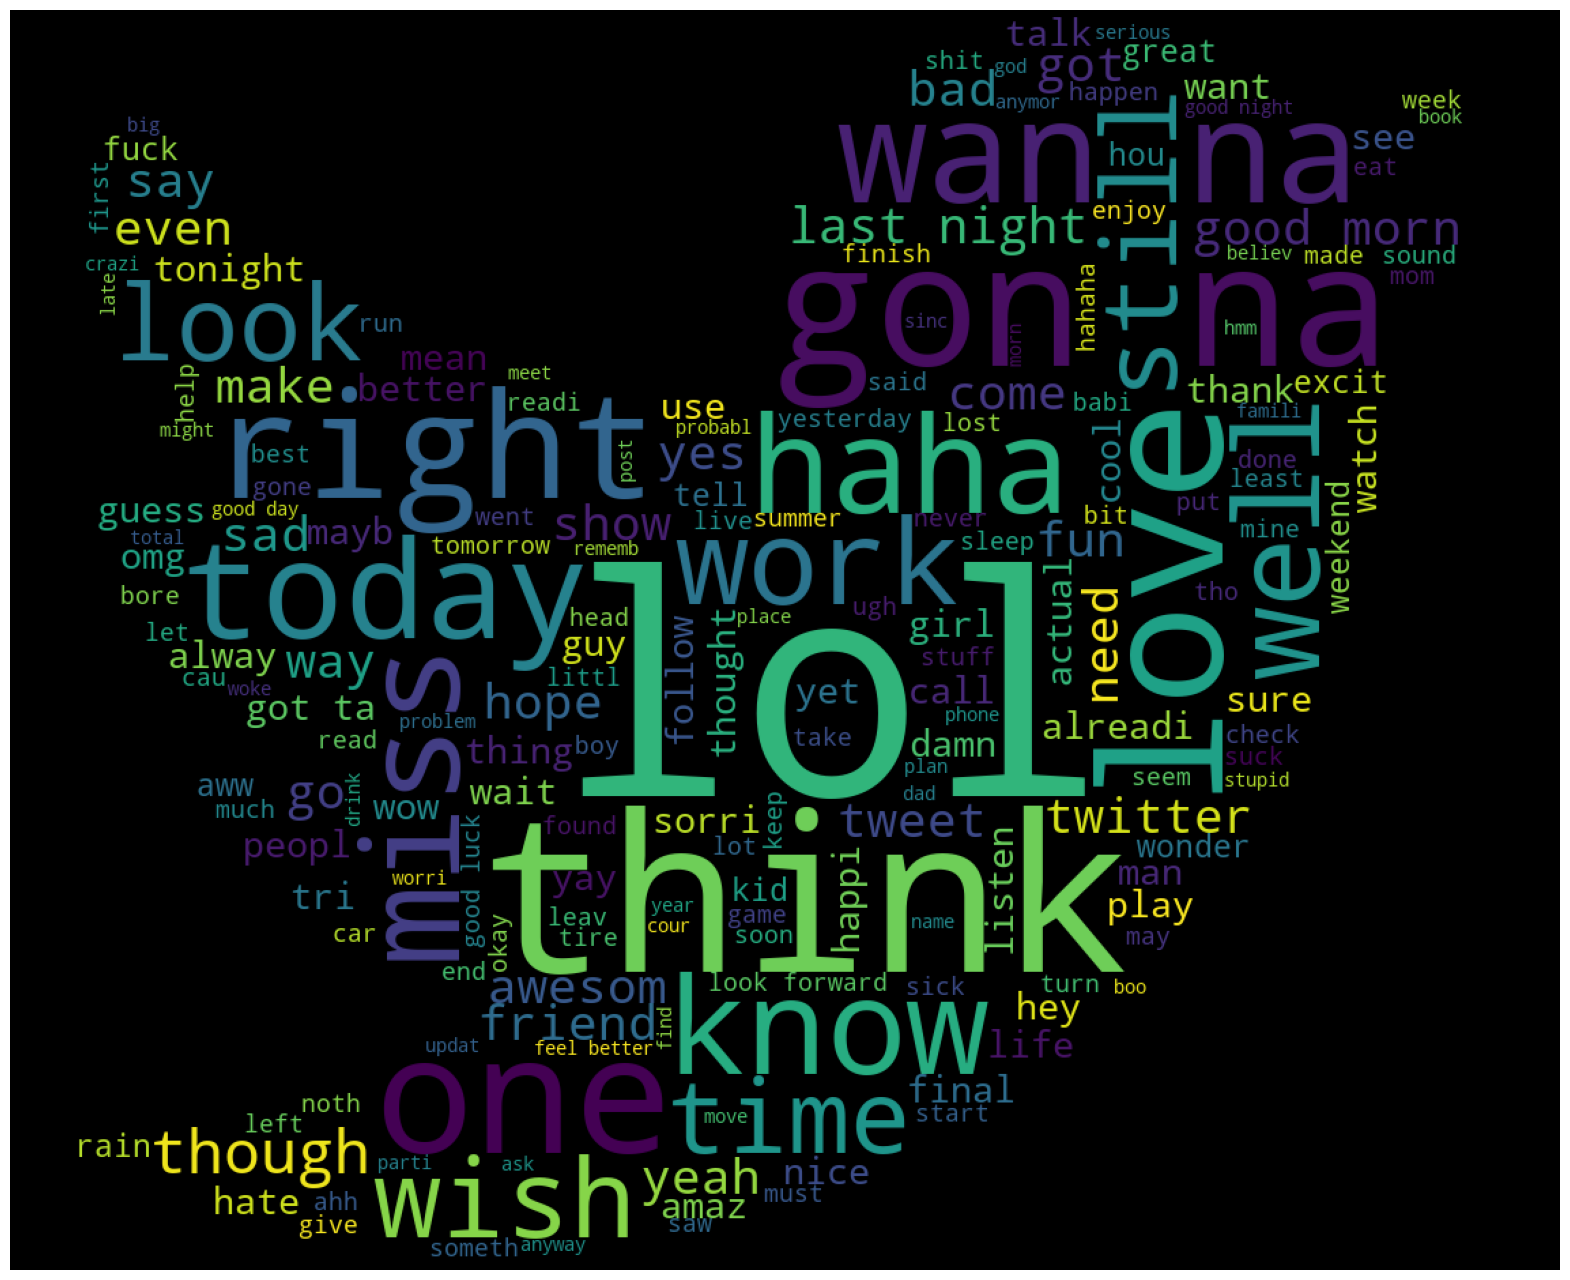

In [20]:
# Load the mask image and convert it to RGB format
mask_url = 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png'
mask_image = Image.open(requests.get(mask_url, stream=True).raw).convert("RGB")
mask = np.array(mask_image)

# Generate the word cloud with the mask
data = df['stemmed_str']
wc = WordCloud(background_color='black', height=1500, width=4000, mask=mask).generate(" ".join(data))

# Apply colors from the mask image to the word cloud

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(wc)
plt.axis('off')
plt.show()

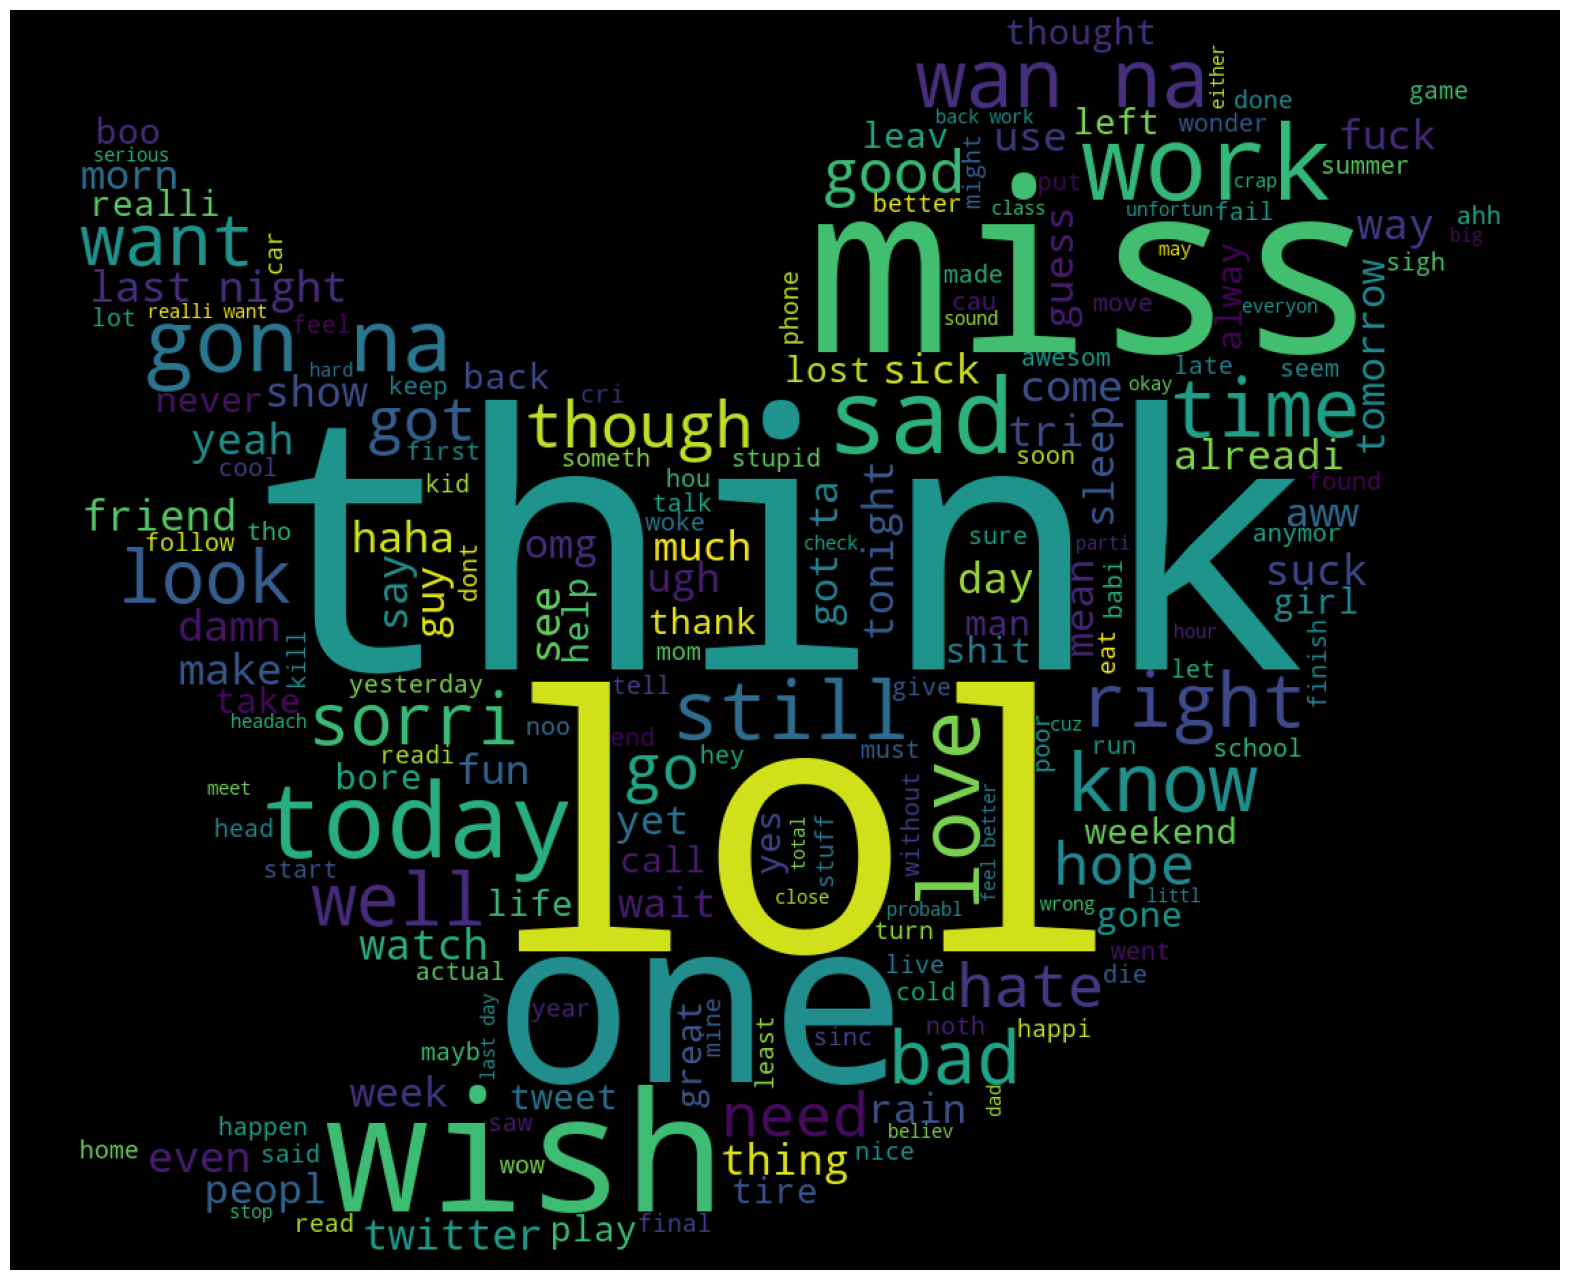

In [21]:
# Load the mask image and convert it to RGB format
mask_url = 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png'
mask_image = Image.open(requests.get(mask_url, stream=True).raw).convert("RGB")
mask = np.array(mask_image)

# Generate the word cloud with the mask
data = df['stemmed_str'][:800000]
wc = WordCloud(background_color='black', height=1500, width=4000, mask=mask).generate(" ".join(data))

# Apply colors from the mask image to the word cloud

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(wc)
plt.axis('off')
plt.show()

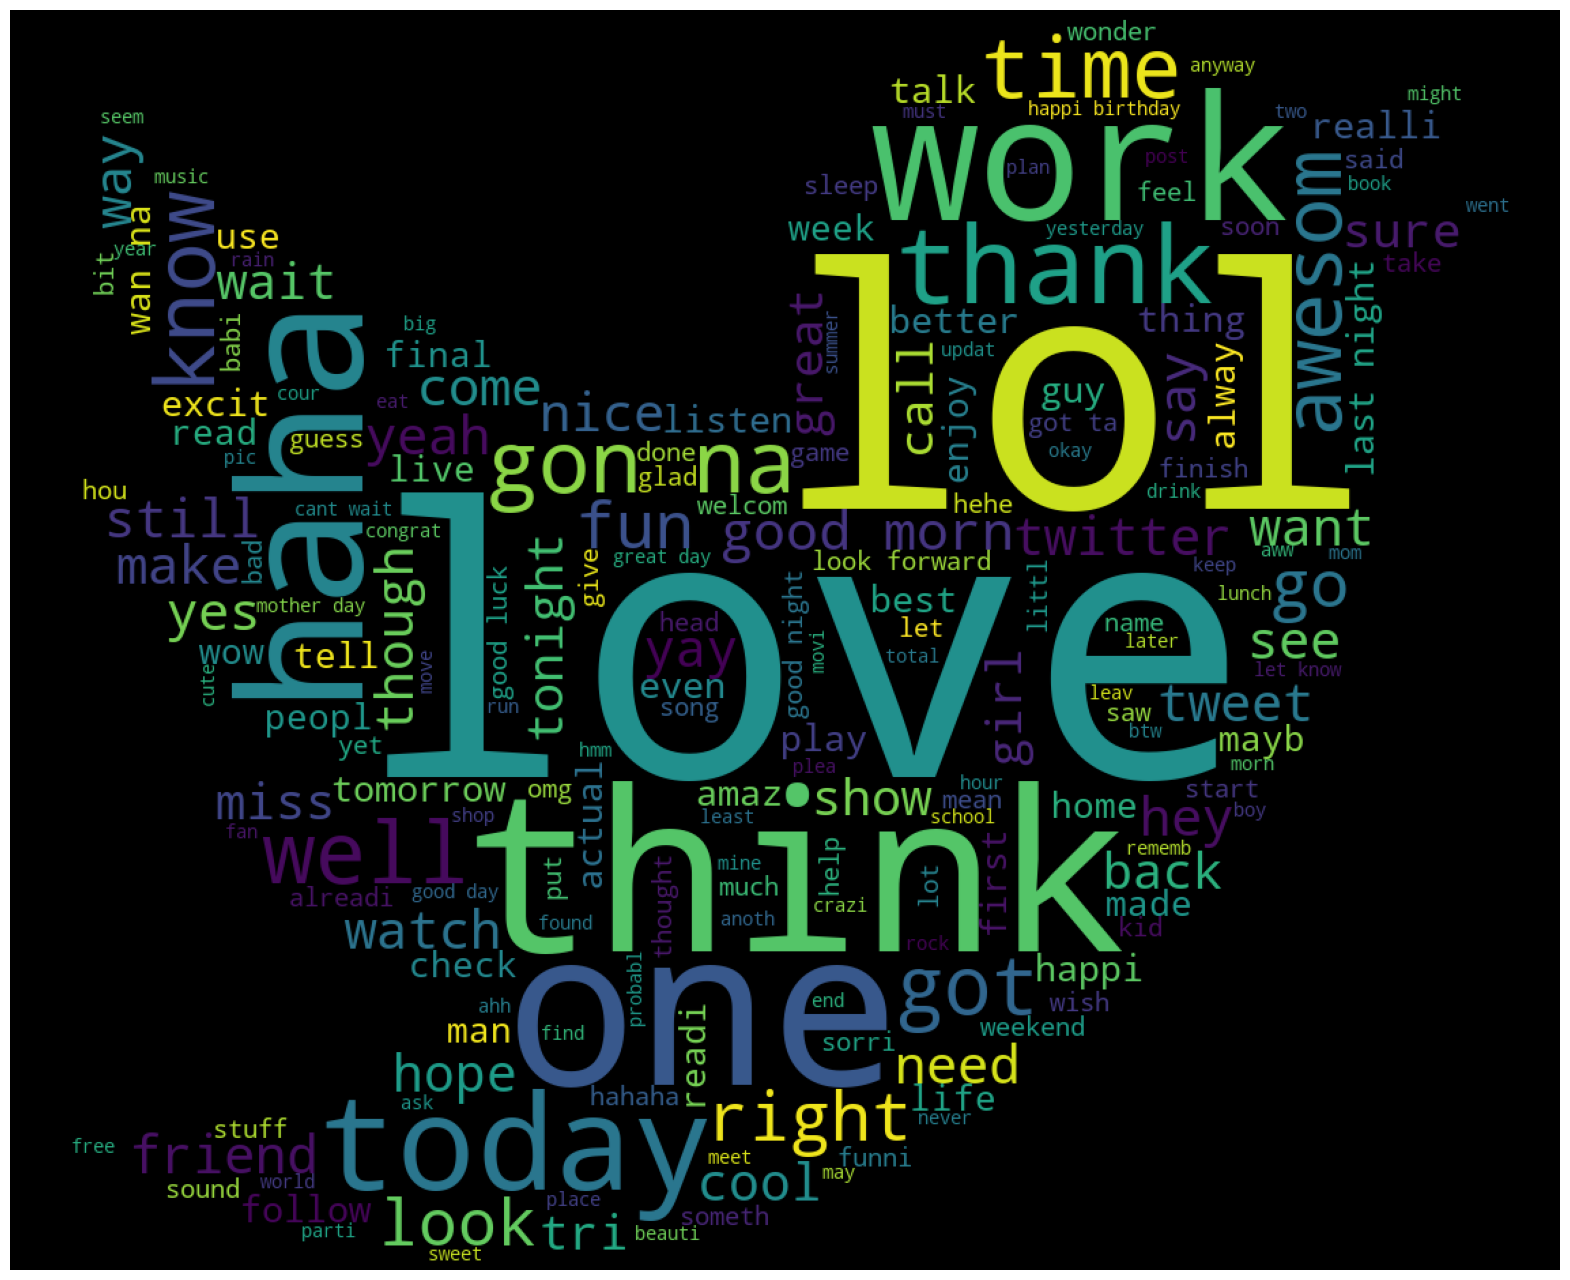

In [22]:
# Load the mask image and convert it to RGB format
mask_url = 'http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png'
mask_image = Image.open(requests.get(mask_url, stream=True).raw).convert("RGB")
mask = np.array(mask_image)

# Generate the word cloud with the mask
data = df['stemmed_str'][800000:]
wc = WordCloud(background_color='black', height=1500, width=4000, mask=mask).generate(" ".join(data))

# Apply colors from the mask image to the word cloud

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_mod['stemmed_str'], df_mod['sentiment'], test_size=0.01, random_state=1)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=200000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=200000, ngram_range=(1, 2))

In [24]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [25]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      7982
           1       0.76      0.81      0.79      8018

    accuracy                           0.78     16000
   macro avg       0.78      0.78      0.78     16000
weighted avg       0.78      0.78      0.78     16000



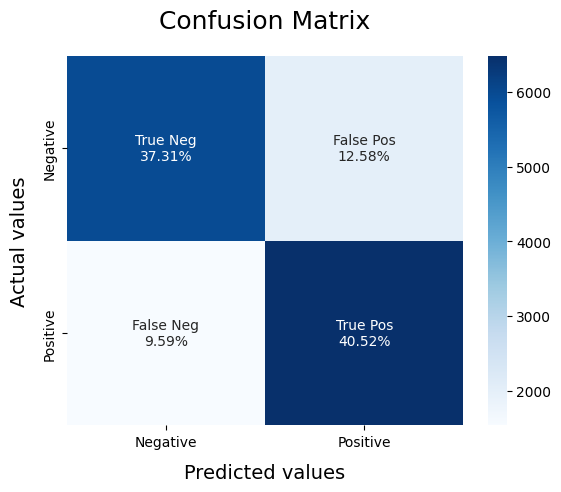

In [26]:
BNBmodel = BernoulliNB(alpha = 2.0)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

In [27]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

BNBmodel = BernoulliNB()
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search = GridSearchCV(BNBmodel, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Best parameter:  {'alpha': 2.0}
Best score:  0.7776710858585858
Accuracy:  0.77825


              precision    recall  f1-score   support

           0       0.79      0.76      0.78      7982
           1       0.77      0.80      0.78      8018

    accuracy                           0.78     16000
   macro avg       0.78      0.78      0.78     16000
weighted avg       0.78      0.78      0.78     16000



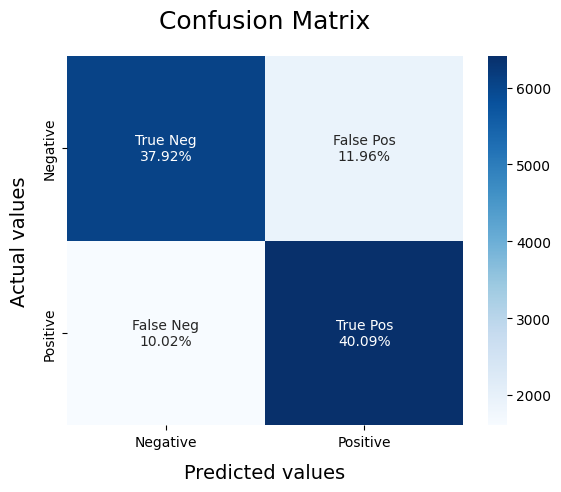

In [28]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       0.80      0.77      0.79      7982
           1       0.78      0.81      0.80      8018

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



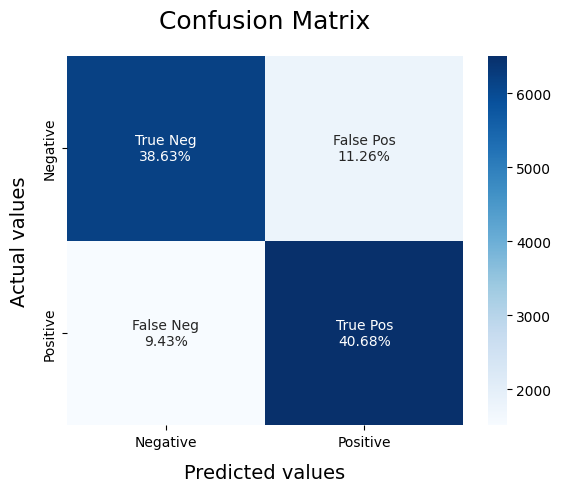

In [29]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.79      0.45      0.57      7982
           1       0.62      0.88      0.73      8018

    accuracy                           0.67     16000
   macro avg       0.70      0.66      0.65     16000
weighted avg       0.70      0.67      0.65     16000



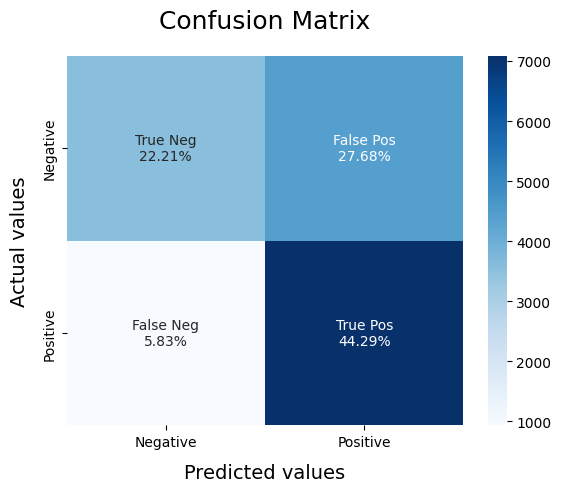

In [30]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=25)
tree.fit(X_train, y_train)
model_Evaluate(tree)